# Target Label-Free Confidence Calibration Under Label Shift
## Calibration on simulated datasets
### Initialization
Set the parameters required to generate the simulated dataset, including preset confidence distribution parameters and preset calibration curves, as shown in the code below. The meaning of the variables in the code is shown in the following table.

| Variables | Meaning |
|---|---|
|Rs|$P(Y=0)$|
|Rt|$Q(Y=0)$|
|alpha1,beta1|Beta distribution parameters $\alpha_{1},\beta_{1}$ to generate confidence score $\hat S\|Y=0$|
|alpha2,beta2|Beta distribution parameters $\alpha_{2},\beta_{2}$ to generate confidence score $\hat S\|Y=1$|
|g1|The preset true calibration curve of the first class, i.e., $P(H = 1\|\hat S,Y = 0)$|
|g2|The preset true calibration curve of the first class, i.e., $P(H = 1\|\hat S,Y = 1)$|

[1] "Mitigating bias in calibration error estimation." In International Conference on Artificial Intelligence and Statistics.

[2] "Combining Priors with Experience: Confidence Calibration Based on Binomial Process Modeling." In Proceedings of the AAAI Conference on Artificial Intelligence.

In [41]:
from Data_preparation import Simulated_data
import True_calibration_curves
import numpy as np
from Histom_binning_estimation import Histom
import matplotlib.pyplot as plt
import pandas as pd


Rs = 0.8  # Class probability of the first class in source domain: $P(Y=0)$
Rt = 0.2  # Class probability of the first class in Target domain: $Q(Y=0)$, i.e., Class probabilities after shift
alpha1,beta1 = 1.92, 0.13  #Beta distribution parameters of the confidence distribution of the first class: $Be(alpha1,beta1)$
alpha2,beta2 = 1.19, 0.14  #Beta distribution parameters of the confidence distribution of the second class: $Be(alpha2,beta2)$
g1 = True_calibration_curves.log_log2()  #The preset true calibration curve of the first class, i.e., $P(H = 1|\hat S,Y = 0)$
g2 = True_calibration_curves.logflip_logflip2()  #The preset true calibration curve of the second class, i.e., $P(H = 1|\hat S,Y = 1)$

#### Obtain and plot the true calibration curves
Before generating simulated data, we can obtain and plot the true calibration curves on the source domain and the target domain. The obtain method is described in Section 4 of the paper. As shown in the code below, the true calibration curve before and after the shift is plotted.

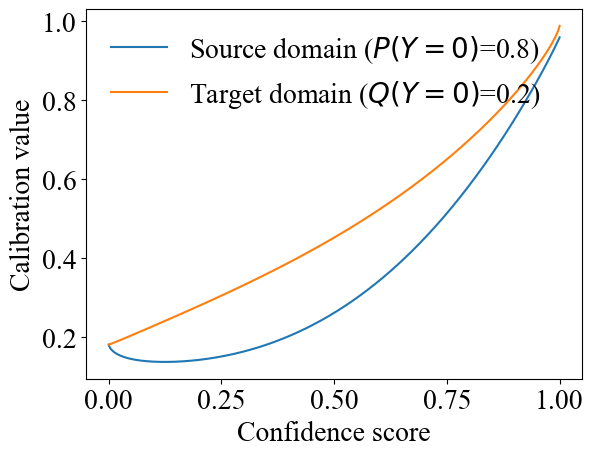

In [42]:
data_generation = Simulated_data(Rs,Rt,alpha1,beta1,alpha2,beta2,g1,g2)
data_generation.plot_effect_of_label_shift()

### Simulating dataset for label shift
See Algorithm 2 of the paper or ./Data_preparation.py

In [43]:
Ds = data_generation.get_dataset()
Dt = data_generation.get_dataset(domain="target")

### Calibration in Simulated Dataset
See Algorithm 1 of the paper.

Best_index: 0
Best_AIC: -544.7483564532365


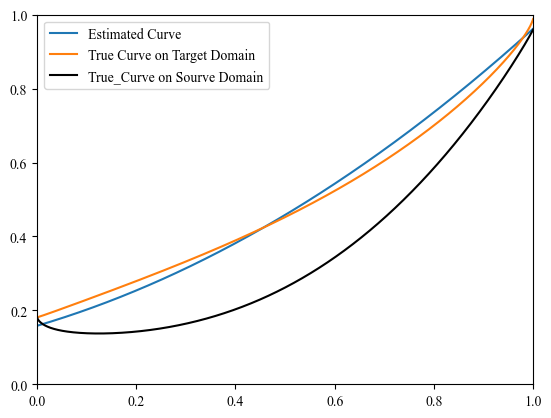

In [47]:
# Calibrating
xs = []
ys = []
for bin_num in [15+i*5 for i in range(15)]: #[15+i*5 for i in range(15)]:
    hbe = Histom(Ds=Ds,Dt=Dt,K=2,bin_num=bin_num)
    D_cali = hbe.Calibrating()
    for sample in D_cali:
        xs.append(sample[0])
        ys.append(sample[1])

xs = np.array(xs)
ys = np.array(ys)
sorted_indices = np.argsort(xs)
xs = xs[sorted_indices]
ys = ys[sorted_indices]

#Fitting
from statsmodels.formula.api import glm
import statsmodels.api as sm
data = pd.DataFrame({'x': xs, 'y': ys})
formulas = [
            "y ~ x + I(x**2)", 
            "y ~ x + I(x**3)", 
            "y ~ I(x**2) + I(x**3)",  
            "y ~ x + I(x**2) + I(x**3)",  
            "y ~ x + I(x**2) + I(x**3)+I(x**4)",
            "y ~ x +I(x**4)",
            "y ~ I(x**2) + I(x**4)",
            "y ~ I(x**3)+I(x**4)"
        ]
models = []
for formula in formulas:
    model = glm(formula=formula, data=data, family=sm.families.Gaussian()).fit()
    models.append((model, model.aic))
scores = [model[1] for model in models]
best_index = np.argmin(scores)
best_model = models[best_index]
print("Best_index:",best_index)
print("Best_AIC:",scores[best_index])
fit_fun = best_model[0].predict

# Plot
xs = np.linspace(0, 1, 1000)
fit_y = fit_fun(pd.DataFrame({'x':xs}))
plt.plot(xs,fit_y,label="Estimated Curve")
# plot target domain curve
y_taeget = data_generation.get_true_curve(xs,domain="target")
plt.plot(xs,y_taeget,label="True Curve on Target Domain")
# plot source domain curve
y_source = data_generation.get_true_curve(xs)
plt.plot(xs,y_source,color="black",label="True_Curve on Sourve Domain")
plt.xlim([0,1])
plt.ylim([0,1])
plt.legend()
plt.show()